In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

In [6]:
# Load and prepare data
path = './datacsv/battery_signature_features.csv'
D = pd.read_csv(path)

x_cols = D.columns[-15:].tolist()  # s_0 to s_14
event_col = ['event']  
time_col = ['time']   

D = D[x_cols + event_col + time_col]

print(f"Dataset shape: {D.shape}")
print(f"Feature columns: {x_cols}")
print(f"Event distribution: {D['event'].value_counts().to_dict()}")

Dataset shape: (2769, 17)
Feature columns: ['s_0', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14']
Event distribution: {0: 1739, 1: 1030}


In [7]:
# Data preprocessing
# Prepare features and labels
X = D[x_cols].values.astype('float32')
y_event = D['event'].values.astype('int')
y_time = D['time'].values.astype('float32')

print(f"X shape: {X.shape}")
print(f"Event shape: {y_event.shape}")
print(f"Time shape: {y_time.shape}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_event_train, y_event_test, y_time_train, y_time_test = train_test_split(
    X_scaled, y_event, y_time, test_size=0.2, random_state=42, stratify=y_event
)

print(f"Train set - X: {X_train.shape}, Event: {y_event_train.shape}, Time: {y_time_train.shape}")
print(f"Test set - X: {X_test.shape}, Event: {y_event_test.shape}, Time: {y_time_test.shape}")

X shape: (2769, 15)
Event shape: (2769,)
Time shape: (2769,)
Train set - X: (2215, 15), Event: (2215,), Time: (2215,)
Test set - X: (554, 15), Event: (554,), Time: (554,)


In [8]:
# CNN-LSTM Model for Survival Analysis
class CNNLSTMSurvivalModel(nn.Module):
    def __init__(self, input_dim, sequence_length=15, cnn_filters=64, lstm_units=128, 
                 num_durations=100, dropout=0.3):
        super(CNNLSTMSurvivalModel, self).__init__()
        
        self.input_dim = input_dim
        self.sequence_length = sequence_length
        self.num_durations = num_durations
        
        # CNN layers (treating features as 1D sequence)
        self.conv1 = nn.Conv1d(1, cnn_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(cnn_filters, cnn_filters*2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=1, padding=0)
        self.dropout1 = nn.Dropout(dropout)
        
        # LSTM layers
        self.lstm = nn.LSTM(cnn_filters*2, lstm_units, batch_first=True, dropout=dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        # Output layers
        self.fc1 = nn.Linear(lstm_units, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output_hazard = nn.Linear(32, num_durations)  # For discrete hazard
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Reshape for CNN: (batch, channels=1, features)
        x = x.unsqueeze(1)  # (batch, 1, 15)
        
        # CNN layers
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.dropout1(x)
        
        # Prepare for LSTM: (batch, sequence, features)
        x = x.transpose(1, 2)  # (batch, seq_len, features)
        
        # LSTM layer
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Use the last output
        x = lstm_out[:, -1, :]  # (batch, lstm_units)
        x = self.dropout2(x)
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        
        # Output hazard probabilities
        hazard = self.sigmoid(self.output_hazard(x))
        
        return hazard

# Initialize model
input_dim = X_train.shape[1]
model = CNNLSTMSurvivalModel(input_dim=input_dim, num_durations=100)

print(f"Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

Model architecture:
CNNLSTMSurvivalModel(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(128, 128, batch_first=True, dropout=0.3)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (output_hazard): Linear(in_features=32, out_features=100, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total parameters: 170692


In [9]:
# Prepare data for PyTorch
# Create discrete time intervals
max_time = max(y_time_train.max(), y_time_test.max())
min_time = min(y_time_train.min(), y_time_test.min())
time_intervals = np.linspace(min_time, max_time, 100)

def discretize_time(times, intervals):
    """Convert continuous time to discrete intervals"""
    return np.digitize(times, intervals) - 1

# Discretize survival times
y_time_train_discrete = discretize_time(y_time_train, time_intervals)
y_time_test_discrete = discretize_time(y_time_test, time_intervals)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_event_train_tensor = torch.LongTensor(y_event_train)
y_event_test_tensor = torch.LongTensor(y_event_test)
y_time_train_tensor = torch.LongTensor(y_time_train_discrete)
y_time_test_tensor = torch.LongTensor(y_time_test_discrete)

print(f"Time intervals: {len(time_intervals)}")
print(f"Time range: {min_time:.2f} to {max_time:.2f}")
print(f"Discrete time range - Train: {y_time_train_discrete.min()} to {y_time_train_discrete.max()}")
print(f"Discrete time range - Test: {y_time_test_discrete.min()} to {y_time_test_discrete.max()}")

Time intervals: 100
Time range: 23.00 to 2519.94
Discrete time range - Train: 0 to 99
Discrete time range - Test: 2 to 99


In [10]:
# Training setup and custom loss function
class SurvivalLoss(nn.Module):
    def __init__(self):
        super(SurvivalLoss, self).__init__()
        
    def forward(self, hazards, events, times):
        """
        Discrete survival loss function
        hazards: predicted hazard probabilities (batch_size, num_durations)
        events: event indicators (batch_size,)
        times: discrete time indices (batch_size,)
        """
        batch_size = hazards.size(0)
        num_durations = hazards.size(1)
        
        # Create survival probabilities
        # S(t) = prod(1 - h(i)) for i <= t
        cumprod_1_minus_hazards = torch.cumprod(1 - hazards, dim=1)
        
        # Calculate log-likelihood
        log_likelihood = 0.0
        
        for i in range(batch_size):
            t = times[i].item()
            e = events[i].item()
            
            # Ensure time index is valid
            t = min(max(t, 0), num_durations - 1)
            
            if e == 1:  # Event occurred
                if t == 0:
                    survival_prob = 1.0
                else:
                    survival_prob = cumprod_1_minus_hazards[i, t-1]
                hazard_prob = hazards[i, t]
                log_likelihood += torch.log(survival_prob * hazard_prob + 1e-8)
            else:  # Censored
                survival_prob = cumprod_1_minus_hazards[i, t]
                log_likelihood += torch.log(survival_prob + 1e-8)
        
        return -log_likelihood / batch_size

# Training function
def train_model(model, X_train, y_event_train, y_time_train, 
                X_test, y_event_test, y_time_test, 
                epochs=100, lr=0.001, batch_size=64):
    
    criterion = SurvivalLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
    
    train_losses = []
    test_losses = []
    
    # Create data loaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_event_train, y_time_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    test_dataset = torch.utils.data.TensorDataset(X_test, y_event_test, y_time_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model.train()
    
    for epoch in range(epochs):
        # Training phase
        train_loss = 0.0
        for batch_X, batch_event, batch_time in train_loader:
            optimizer.zero_grad()
            hazards = model(batch_X)
            loss = criterion(hazards, batch_event, batch_time)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_event, batch_time in test_loader:
                hazards = model(batch_X)
                loss = criterion(hazards, batch_event, batch_time)
                test_loss += loss.item()
        
        model.train()
        
        train_loss /= len(train_loader)
        test_loss /= len(test_loader)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        scheduler.step(test_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    return train_losses, test_losses

print("Training setup complete. Ready to train the CNN-LSTM survival model.")

Training setup complete. Ready to train the CNN-LSTM survival model.


Starting CNN-LSTM model training...
Epoch [0/100], Train Loss: 17.5691, Test Loss: 15.7538
Epoch [0/100], Train Loss: 17.5691, Test Loss: 15.7538
Epoch [10/100], Train Loss: 0.9089, Test Loss: 0.9990
Epoch [10/100], Train Loss: 0.9089, Test Loss: 0.9990
Epoch [20/100], Train Loss: 0.6969, Test Loss: 0.6653
Epoch [20/100], Train Loss: 0.6969, Test Loss: 0.6653
Epoch [30/100], Train Loss: 0.6287, Test Loss: 0.5964
Epoch [30/100], Train Loss: 0.6287, Test Loss: 0.5964
Epoch [40/100], Train Loss: 0.5683, Test Loss: 0.5218
Epoch [40/100], Train Loss: 0.5683, Test Loss: 0.5218
Epoch [50/100], Train Loss: 0.5300, Test Loss: 0.5688
Epoch [50/100], Train Loss: 0.5300, Test Loss: 0.5688
Epoch [60/100], Train Loss: 0.5144, Test Loss: 0.5573
Epoch [60/100], Train Loss: 0.5144, Test Loss: 0.5573
Epoch [70/100], Train Loss: 0.4594, Test Loss: 0.4191
Epoch [70/100], Train Loss: 0.4594, Test Loss: 0.4191
Epoch [80/100], Train Loss: 0.4473, Test Loss: 0.4509
Epoch [80/100], Train Loss: 0.4473, Test Los

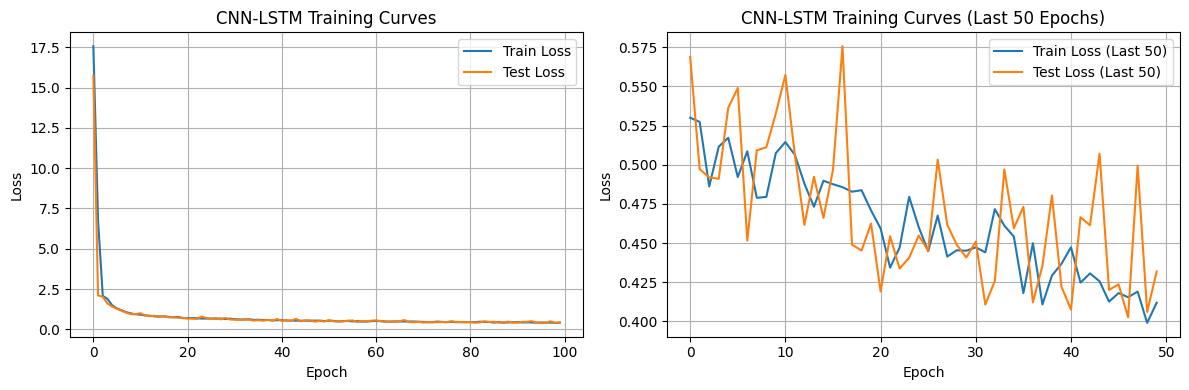

Training completed!


In [11]:
# Train the CNN-LSTM model
print("Starting CNN-LSTM model training...")
train_losses, test_losses = train_model(
    model, 
    X_train_tensor, y_event_train_tensor, y_time_train_tensor,
    X_test_tensor, y_event_test_tensor, y_time_test_tensor,
    epochs=100, 
    lr=0.001, 
    batch_size=32
)

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN-LSTM Training Curves')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses[-50:], label='Train Loss (Last 50)')
plt.plot(test_losses[-50:], label='Test Loss (Last 50)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN-LSTM Training Curves (Last 50 Epochs)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Training completed!")

In [12]:
# Model evaluation and predictions
model.eval()

def predict_survival(model, X, time_intervals):
    """Generate survival predictions"""
    with torch.no_grad():
        hazards = model(X)
        
        # Calculate survival probabilities
        survival_probs = torch.cumprod(1 - hazards, dim=1)
        
        # Calculate cumulative hazard
        cumulative_hazard = -torch.log(survival_probs + 1e-8)
        
    return hazards.numpy(), survival_probs.numpy(), cumulative_hazard.numpy()

# Generate predictions
hazards_train, surv_probs_train, cum_hazard_train = predict_survival(model, X_train_tensor, time_intervals)
hazards_test, surv_probs_test, cum_hazard_test = predict_survival(model, X_test_tensor, time_intervals)

print(f"Train predictions shape - Hazards: {hazards_train.shape}, Survival: {surv_probs_train.shape}")
print(f"Test predictions shape - Hazards: {hazards_test.shape}, Survival: {surv_probs_test.shape}")

# Calculate C-index (concordance index)
def concordance_index(y_time, y_event, predictions):
    """Calculate concordance index"""
    n = len(y_time)
    concordant = 0
    total_pairs = 0
    
    for i in range(n):
        for j in range(i + 1, n):
            if y_event[i] == 1 or y_event[j] == 1:
                total_pairs += 1
                if y_time[i] < y_time[j] and predictions[i] > predictions[j]:
                    concordant += 1
                elif y_time[i] > y_time[j] and predictions[i] < predictions[j]:
                    concordant += 1
    
    return concordant / total_pairs if total_pairs > 0 else 0.0

# Use cumulative hazard at median time for ranking
median_time_idx = len(time_intervals) // 2
train_c_index = concordance_index(y_time_train, y_event_train, cum_hazard_train[:, median_time_idx])
test_c_index = concordance_index(y_time_test, y_event_test, cum_hazard_test[:, median_time_idx])

print(f"\nConcordance Index:")
print(f"Train C-index: {train_c_index:.4f}")
print(f"Test C-index: {test_c_index:.4f}")

Train predictions shape - Hazards: (2215, 100), Survival: (2215, 100)
Test predictions shape - Hazards: (554, 100), Survival: (554, 100)

Concordance Index:
Train C-index: 0.8523
Test C-index: 0.8507

Concordance Index:
Train C-index: 0.8523
Test C-index: 0.8507


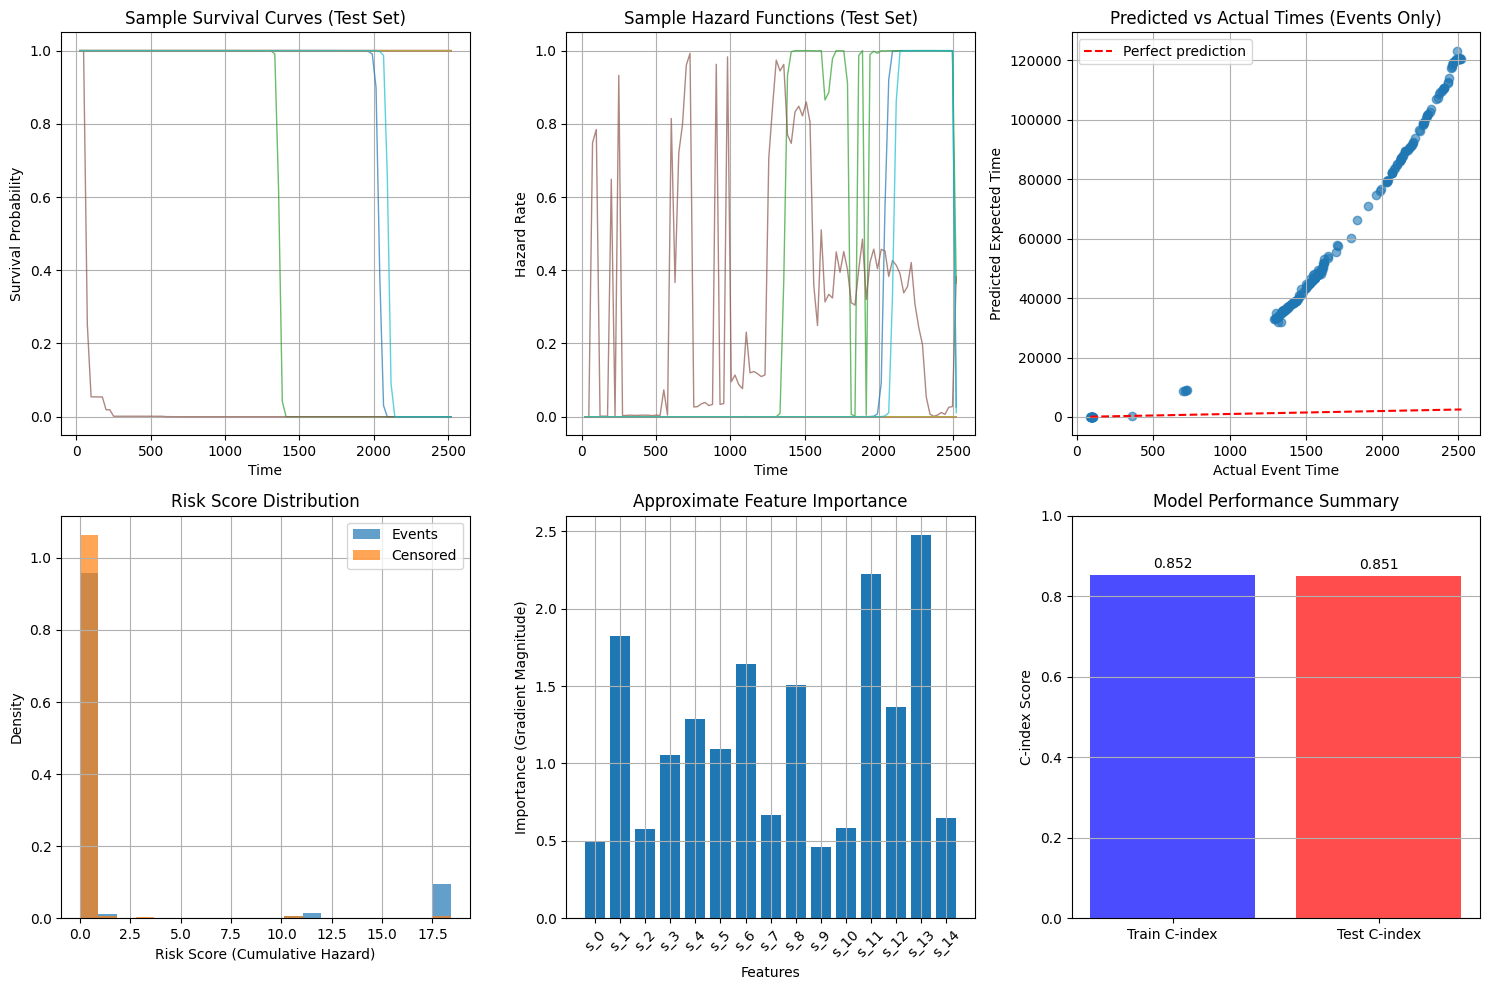


CNN-LSTM SURVIVAL MODEL SUMMARY
Dataset: 2769 samples, 15 features
Training samples: 2215
Test samples: 554
Event rate - Train: 0.372
Event rate - Test: 0.372
Time range: 23.00 - 2519.94
Model parameters: 170692
Final train loss: 0.4119
Final test loss: 0.4319
Train C-index: 0.8523
Test C-index: 0.8507


In [13]:
# Visualization of results
plt.figure(figsize=(15, 10))

# Plot 1: Sample survival curves
plt.subplot(2, 3, 1)
sample_indices = np.random.choice(len(X_test_tensor), 10, replace=False)
for i in sample_indices:
    plt.plot(time_intervals, surv_probs_test[i], alpha=0.7, linewidth=1)
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Sample Survival Curves (Test Set)')
plt.grid(True)

# Plot 2: Hazard functions
plt.subplot(2, 3, 2)
for i in sample_indices:
    plt.plot(time_intervals, hazards_test[i], alpha=0.7, linewidth=1)
plt.xlabel('Time')
plt.ylabel('Hazard Rate')
plt.title('Sample Hazard Functions (Test Set)')
plt.grid(True)

# Plot 3: Predicted vs actual event times (for events only)
plt.subplot(2, 3, 3)
event_mask = y_event_test == 1
if np.sum(event_mask) > 0:
    # Use expected survival time as prediction
    expected_times = np.sum(surv_probs_test * time_intervals.reshape(1, -1), axis=1)
    plt.scatter(y_time_test[event_mask], expected_times[event_mask], alpha=0.6)
    plt.plot([y_time_test.min(), y_time_test.max()], [y_time_test.min(), y_time_test.max()], 'r--', label='Perfect prediction')
    plt.xlabel('Actual Event Time')
    plt.ylabel('Predicted Expected Time')
    plt.title('Predicted vs Actual Times (Events Only)')
    plt.legend()
    plt.grid(True)

# Plot 4: Risk scores distribution
plt.subplot(2, 3, 4)
risk_scores_event = cum_hazard_test[y_event_test == 1, median_time_idx]
risk_scores_censor = cum_hazard_test[y_event_test == 0, median_time_idx]

plt.hist(risk_scores_event, bins=20, alpha=0.7, label='Events', density=True)
plt.hist(risk_scores_censor, bins=20, alpha=0.7, label='Censored', density=True)
plt.xlabel('Risk Score (Cumulative Hazard)')
plt.ylabel('Density')
plt.title('Risk Score Distribution')
plt.legend()
plt.grid(True)

# Plot 5: Feature importance (approximate using gradients)
plt.subplot(2, 3, 5)
model.eval()
sample_input = X_test_tensor[:100]  # Use first 100 samples
sample_input.requires_grad_(True)

output = model(sample_input)
loss = output.sum()
loss.backward()

feature_importance = torch.abs(sample_input.grad).mean(dim=0).detach().numpy()
feature_names = [f's_{i}' for i in range(len(feature_importance))]

plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Features')
plt.ylabel('Importance (Gradient Magnitude)')
plt.title('Approximate Feature Importance')
plt.xticks(range(len(feature_names)), feature_names, rotation=45)
plt.grid(True)

# Plot 6: Model performance summary
plt.subplot(2, 3, 6)
metrics = ['Train C-index', 'Test C-index']
values = [train_c_index, test_c_index]
colors = ['blue', 'red']

bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.ylabel('C-index Score')
plt.title('Model Performance Summary')
plt.ylim(0, 1)

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom')

plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("CNN-LSTM SURVIVAL MODEL SUMMARY")
print("="*60)
print(f"Dataset: {D.shape[0]} samples, {len(x_cols)} features")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Event rate - Train: {np.mean(y_event_train):.3f}")
print(f"Event rate - Test: {np.mean(y_event_test):.3f}")
print(f"Time range: {min_time:.2f} - {max_time:.2f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final test loss: {test_losses[-1]:.4f}")
print(f"Train C-index: {train_c_index:.4f}")
print(f"Test C-index: {test_c_index:.4f}")
print("="*60)

In [11]:
# Save model and results
import datetime

# Create timestamp for unique filename
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"cnn_lstm_survival_model_{timestamp}.pt"

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler': scaler,
    'time_intervals': time_intervals,
    'input_dim': input_dim,
    'train_c_index': train_c_index,
    'test_c_index': test_c_index,
    'train_losses': train_losses,
    'test_losses': test_losses
}, model_filename)

print(f"Model saved as: {model_filename}")

# Save predictions to CSV
results_df = pd.DataFrame({
    'sample_id': range(len(y_time_test)),
    'actual_time': y_time_test,
    'actual_event': y_event_test,
    'predicted_risk': cum_hazard_test[:, median_time_idx],
    'predicted_survival_prob': surv_probs_test[:, median_time_idx]
})

results_filename = f"cnn_lstm_predictions_{timestamp}.csv"
results_df.to_csv(results_filename, index=False)

print(f"Predictions saved as: {results_filename}")

# Display sample predictions
print("\nSample predictions (first 10 test samples):")
print(results_df.head(10))

Model saved as: cnn_lstm_survival_model_2025-10-11_16-33-52.pt
Predictions saved as: cnn_lstm_predictions_2025-10-11_16-33-52.csv

Sample predictions (first 10 test samples):
   sample_id  actual_time  actual_event  predicted_risk  \
0          0  1582.390991             1    1.609327e-06   
1          1  2511.156982             0    9.238763e-06   
2          2  1557.937012             1    2.205374e-06   
3          3  2205.264893             1   -0.000000e+00   
4          4  1385.375000             1    5.000955e-05   
5          5  1500.265991             1    5.304827e-06   
6          6  2408.781006             0    2.264979e-06   
7          7  1574.468994             0    5.960464e-08   
8          8  2513.187012             0    1.209982e-05   
9          9  2506.233887             0    8.225475e-06   

   predicted_survival_prob  
0                 0.999998  
1                 0.999991  
2                 0.999998  
3                 1.000000  
4                 0.999950  
5